# La idea de este notebook es explorar el algoritmo de reconstrucción de redes propuesto por https://arxiv.org/pdf/nlin/0111023.pdf
# Nos interesa aplicar esta idea en grafos de palabras, y así reconstruir una lengua desde versiones aleatorias e incluso desde otras lenguas.

## (1) Leemos los datos :)

In [1]:
import pickle

## información sobre familias lingüísticas

families_languages = pickle.load(open('families_languages_sim.p','rb'))

In [2]:
families_languages

{'Jivaroan': ['acu', 'agr', 'jiv'],
 'Panoan': ['amc', 'cbr', 'cbs', 'mcd', 'mcf', 'shp'],
 'Arawakan': ['ame', 'cab', 'cni', 'cot', 'cpu', 'guc', 'not', 'prq'],
 'Harakmbut': ['amr'],
 'Zaparoan': ['arl', 'zro'],
 'Araucanian': ['arn'],
 'Aymara': ['ayr'],
 'Boran': ['boa'],
 'Mayan': ['cak', 'hus', 'kek', 'mam', 'quc', 'toj', 'tzh', 'yua'],
 'Barbacoan': ['cbi', 'cof', 'kwi'],
 'Cahuapanan': ['cbt'],
 'Otomanguean': ['chj', 'csa', 'maz', 'mxv', 'mzi', 'ote', 'zam', 'ztu'],
 'Muskogean': ['cic'],
 'Algic': ['csw', 'mic', 'ojb'],
 'Tacanan': ['ese'],
 'Tupian': ['gug', 'gyr'],
 'Yanomam': ['guu'],
 'Indo-European': ['hns', 'pap'],
 'Huitotoan': ['huu'],
 'Eskimo-Aleut': ['ike', 'kal'],
 'Misumalpan': ['miq'],
 'Mixe-Zoque': ['mto'],
 'Athapaskan-Eyak-Tlingit': ['nav'],
 'Uto-Aztecan': ['nhn', 'ppl'],
 'Quechuan': ['qud',
  'qug',
  'quy',
  'quz',
  'qva',
  'qvc',
  'qvh',
  'qvm',
  'qvn',
  'qwh',
  'qxa',
  'qxn',
  'qxu'],
 'Tucanoan': ['sey', 'snn'],
 'Ticuna-Yuri': ['tca'],
 'Gu

In [3]:
## grafos de palabras

graphs = pickle.load(open('graphs.p','rb'))

## (2) Algunas funciones sobre grafos

In [4]:
## Spectrum :)

from scipy.linalg import eigvalsh
import statsmodels.api as sm
import numpy as np
import networkx as nx

def spectrum(G):
    data=np.array(eigvalsh(nx.normalized_laplacian_matrix(G, weight='weight').todense()))
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit(bw=0.065) # Estimate the densities
    X=np.linspace(0, 2, num=1000)
    prediction=[kde.evaluate(x) for x in X]
    return prediction

In [5]:
def distance(S,T):
    return np.mean([np.abs(x-y) for x,y in zip(S,T)])

In [6]:
## Quechua vs Maya

distance(spectrum(graphs['hus']),spectrum(graphs['cak']))

0.06181933432139724

## (3) Grafiquemos la distribución de valores propios

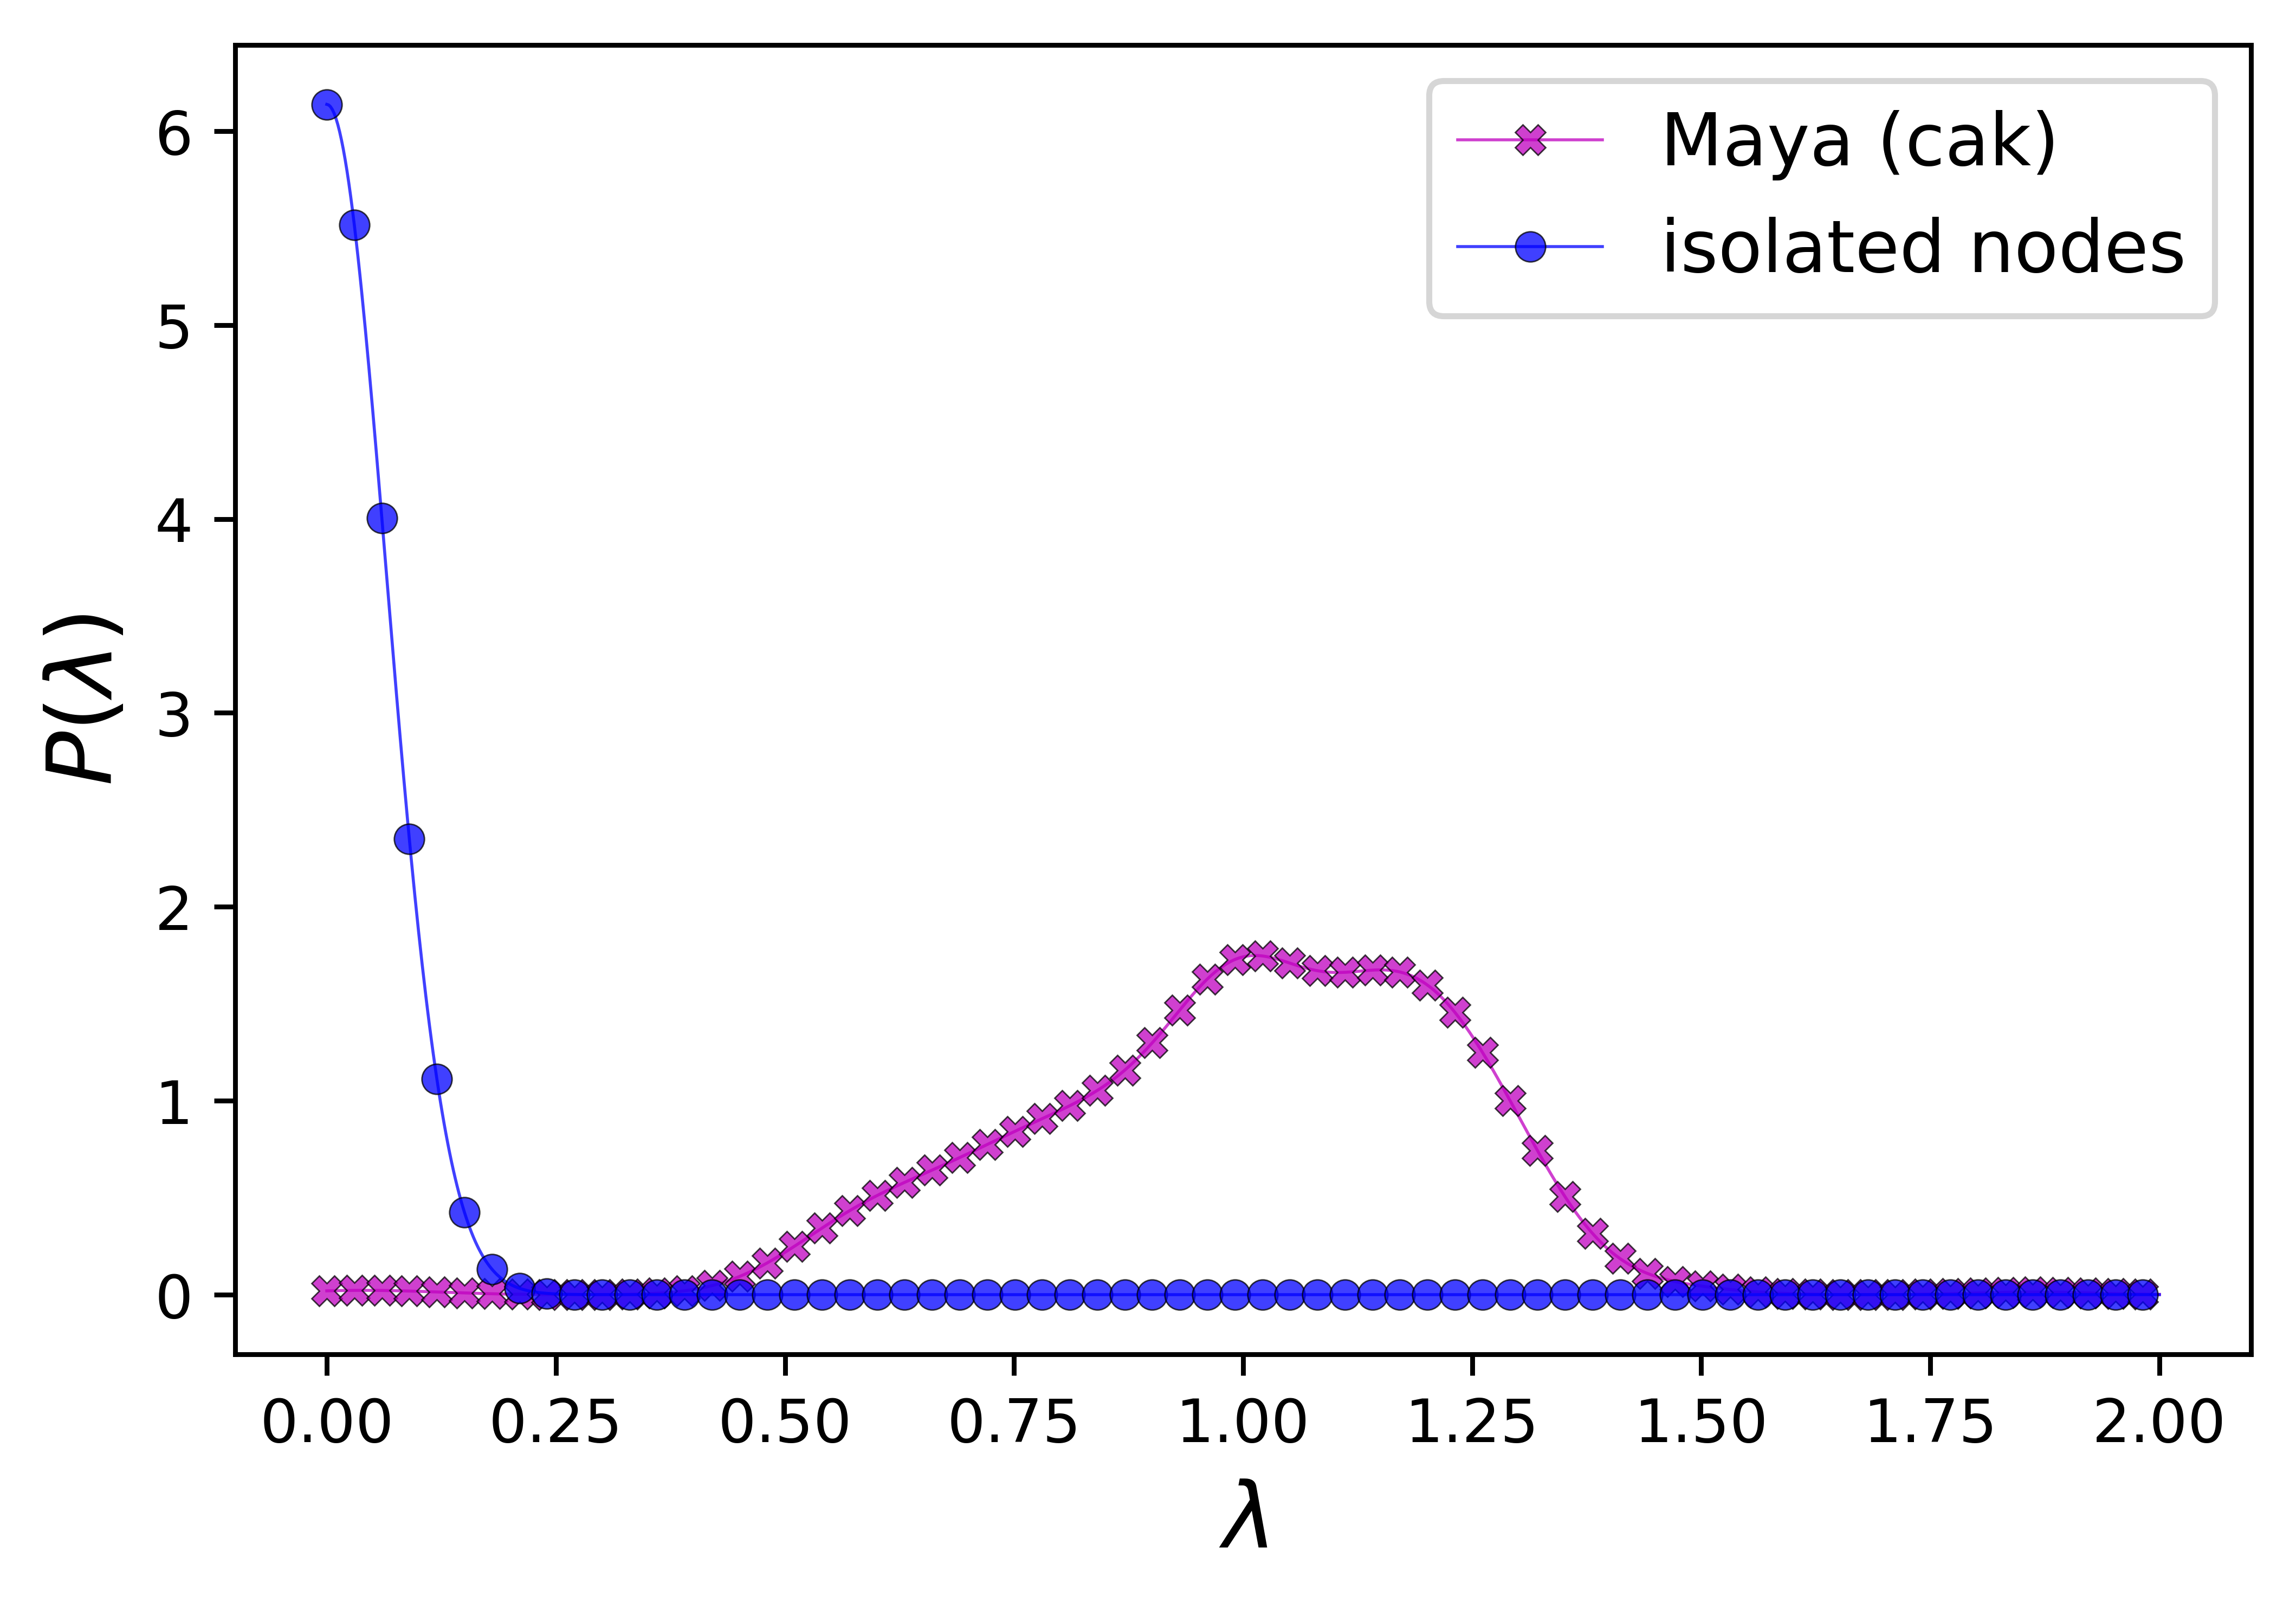

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=800)

X=np.linspace(0, 2, num=1000)

M = spectrum(graphs['cak'])
G0 = graphs['cak'] ## Maya
G = G0.copy()
edges=G.edges()
G.remove_edges_from(list(edges))
    
G2 = G.copy()
Q = spectrum(G2)

ax.plot(X, M, markevery=15,marker='X',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='m', zorder=10, label='Maya (cak)')
ax.plot(X, Q, markevery=15,marker='o',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='b', zorder=10, label='isolated nodes')

plt.legend(loc='best',fontsize=12)
#plt.xlim([-10,10])
#plt.ylim([0., 3])
plt.xlabel(r'$\lambda$',fontsize=15)
plt.ylabel(r'$P(\lambda)$',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('spectrum_random.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

## (4) Mutación y selección

In [8]:
## mutación
import random

def mutation(G):
    
    Gp = G.copy()
    node = random.choice(list(Gp.nodes()))
    ## remove connections
    nodes = dict(Gp[node]).keys()
    for n in nodes:
        Gp[node][n]['weight']=0
        #Gp.remove_edge(node,n)
    new_degree = random.randint(1,len(G)-1)
    selected_nodes = random.sample(list(G.nodes()),new_degree)
    for n in selected_nodes:
        Gp.add_edge(node,n,weight=1)
    return Gp

In [9]:
def energy(G):
    S=eigvalsh(nx.normalized_laplacian_matrix(G, weight='weight').todense())
    return sum([np.abs(x-1) for x in S])/float(len(S))

In [10]:
print(energy(graphs['cak']),energy(graphs['qud']))

0.1748813814000251 0.26564161603748637


### simulación basada en distancia!

In [ ]:
T=10000

G0 = graphs['cak'] ## Maya
G = G0.copy()
#for i in range(int(len(G.edges())/float(10))):
#    nx.double_edge_swap(G)
edges=G.edges()
G.remove_edges_from(list(edges))
    
G2 = G.copy()
    
D=[]
C=[]
P=[]
for t in range(T):
    Gp=mutation(G)
    distancep0=distance(spectrum(Gp),spectrum(G0))
    distanceGG0=distance(spectrum(G),spectrum(G0))
    D+=[distanceGG0]
    P+=[nx.average_shortest_path_length(max(nx.connected_component_subgraphs(G), key=len))/float(nx.average_shortest_path_length(max(nx.connected_component_subgraphs(G0), key=len)))]
    C+=[nx.average_clustering(G)/float(nx.average_clustering(G0))]
    
    if distanceGG0<=0.05:
        G = Gp.copy()
        break
        
    if distancep0-distanceGG0<0:
        G = Gp.copy()
    else:
        if random.random() > np.exp(-(distancep0-distanceGG0)/float(distanceGG0*10)):
            G = Gp.copy()

In [ ]:
fig, ax = plt.subplots(dpi=800)

X=np.linspace(0, 2, num=1000)

Q = spectrum(G2)
M = spectrum(G0)
Msim = spectrum(G)

ax.plot(X, Q, markevery=15,marker='o',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='b', zorder=10, label='isolated nodes')
ax.plot(X, M, markevery=15,marker='X',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='m', zorder=10, label='Maya')
ax.plot(X, Msim,markevery=15,marker='o',markersize=5,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=0.5, alpha=0.75, color='k', zorder=10, label='simulated Maya')

plt.legend(loc='best',fontsize=10)
#plt.xlim([-10,10])
#plt.ylim([0., 3])
plt.xlabel(r'$\lambda$',fontsize=15)
plt.ylabel(r'$P(\lambda)$',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('spectrum_sim_random.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [ ]:
fig, ax = plt.subplots(dpi=800)

X=np.linspace(0, 2, num=1000)


ax.semilogx(range(len(D)), D, marker='o',markersize=0,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=1.5, linestyle = '-',alpha=0.75, color='b', zorder=10, label='distance')
ax.semilogx(range(len(P)), P, marker='o',markersize=0,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=1.5, linestyle = '--',alpha=0.75, color='k', zorder=10, label='average shortest path')
ax.semilogx(range(len(C)), C, marker='o',markersize=0,markeredgecolor='k',markeredgewidth=0.25,fillstyle='full', lw=1.5, linestyle = '-.',alpha=0.75, color='m', zorder=10, label='average clustering')

plt.legend(loc='best',fontsize=10)
#plt.xlim([-10,10])
#plt.ylim([0., 3])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'isolated nodes $\rightarrow$ Maya (cak)',fontsize=12)
plt.rcParams.update({'font.size': 10})
plt.savefig('time_rec_random.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [ ]:
print(D[-1],C[-1],P[-1])

In [ ]:
print(D[0],C[0],P[0])